# Phase 4 AstroPi team Atlantes 2021-2022

## Introduction

In this phase 4 of the project, we will have the data generated in phase 3 by our code running on the Astro Pi IR on board the ISS. The aim of our project is to build Minecraft worlds from the data, i.e. to proceed to its [gamification](https://en.wikipedia.org/wiki/Gamification).

We chose the [Life on Earth](https://astro-pi.org/mission-space-lab/guidelines/life-on-earth) mode with the Astro Pi IR in order to be able to do NDVI analysis of the pictures. On the one hand, this will allow us to see how the new Astro Pi Mark II hardware performs in order to base future projects on this type of analysis. On the other hand, we hope that the colourful pictures produced by the NDVI conversion will be interesting and attractive to generate worlds in Minecraft.

## Setting up the environment

For this notebook to run correctly, some packages need to be installed on the base system. We will also need the data collected on the ISS and some auxiliary files.

Code cells that use the Minecraft Pi API cannot be run on Google Colab as Minecraft Pi needs to be running on the same system where the notebook is executing. If you want to run such cells, you will need to install a Jupyter environment on a conventional Linux machine (it has to be Linux because there is no Minecraft Pi for Windows). However, screenshots of the result of running these cells have been included in the notebook so that the explanation can be followed from Google Colab.

In [1]:
!pip install geopandas matplotlib jupyter mcpi opencv-python
!wget https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_files_for_colab.zip -O atlantes_files_for_colab.zip
!unzip -o -q atlantes_files_for_colab.zip

You should consider upgrading via the '/home/edumoreno/.virtualenvs/astropi2021-2022/bin/python -m pip install --upgrade pip' command.
--2022-06-02 15:34:05--  https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_files_for_colab.zip
Resolviendo niubit.net (niubit.net)... 167.86.121.85
Conectando con niubit.net (niubit.net)[167.86.121.85]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 901693103 (860M) [application/zip]
Guardando como: “atlantes_files_for_colab.zip”

atlantes_files_for_ 100%[===================>] 859,92M  3,11MB/s    en 98s     

2022-06-02 15:35:43 (8,76 MB/s) - “atlantes_files_for_colab.zip” guardado [901693103/901693103]



The next code cell finishes setting up the environment and defines some variables.

In [2]:
%pylab inline
import os

# Adjusting chart dimensions    
plt.rcParams["figure.figsize"] = (10, 8)                  # Size of charts in inches
plt.rcParams["figure.dpi"] = 90                           # Resolution of charts in DPIs

# Defining some environment variables for data sources
path = os.path.dirname(os.path.realpath("__file__"))
path_atlantes = os.path.join(path, 'atlantes')
path_images = os.path.join(path, 'images')

RESULTS_FILE = "atlantes.csv"                             # ESA CSV file

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Learning to work with data

One of the first things we are going to try to gamify data in Minecraft is to draw graphs with it in the game. In order to do this, we first need to master a series of Python techniques to access and manage the data in the CSV file.

The following code block uses the [`pandas`](https://pandas.pydata.org/pandas-docs/stable/index.html) Python library to read the CSV file. It loads the file on a data structure that greatly facilitates the manipulation of data arrays in the style of a spreadsheet. We are going to start by printing the data structure directly on screen to see what we have in hands. As it will contain a lot of data, we are going to see only the first two rows, which we achieve with the `head()` function:

In [3]:
import os
import csv
import pandas

# Building file path
file = os.path.join(path_atlantes, RESULTS_FILE)

# Loading CSV file on memory
data = pandas.read_csv(file)
cut_data = data.head(2)                 # We get only the first two rows

print(cut_data)

                     datetime picture_file  latitude   longitude  \
0  2022-04-26 08:11:03.312399     BLACKOUT  2.116583 -102.057308   
1  2022-04-26 08:11:18.312405     BLACKOUT  2.818594 -101.561826   

       elevation  temp_cpu  temp_h  temp_p  humidity  pressure  ...     yaw  \
0  414782.310944     45.28   39.98   38.42     50.02   1010.98  ...  295.81   
1  414672.561371     49.66   39.93   38.42     49.25   1010.97  ...  297.25   

    mag_x   mag_y   mag_z   accel_x   accel_y   accel_z    gyro_x    gyro_y  \
0  10.415 -6.2046  2.0359  0.017080 -0.007076 -0.007808  0.001676  0.002064   
1  16.692 -9.7648  2.8616  0.019032 -0.005612 -0.007076  0.002236 -0.000909   

     gyro_z  
0 -0.000903  
1 -0.000055  

[2 rows x 22 columns]


When we want a single column of data, it will be as simple as indicating the name of the column (the first value of the column in the CSV file that acts as a header) separated from the data structure with a period:

In [4]:
import os
import csv
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE)

data = pandas.read_csv(file)
sub_data = data.latitude                # Data subset with 'latitude' column
cut_data = sub_data.head(2)             # We get only the first two rows

print(cut_data)

0    2.116583
1    2.818594
Name: latitude, dtype: float64


When we want a set of columns, that is, a kind of subset of the CSV sheet, we will use the [`loc`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) property as follows:

In [5]:
import os
import csv
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE)

data = pandas.read_csv(file)
# Data subset with 4 specific columns
sub_data = data.loc[:, ["datetime", "picture_file", "latitude", "longitude"]]
cut_data = sub_data.head(2)             # We get only the first two rows

print(cut_data)

                     datetime picture_file  latitude   longitude
0  2022-04-26 08:11:03.312399     BLACKOUT  2.116583 -102.057308
1  2022-04-26 08:11:18.312405     BLACKOUT  2.818594 -101.561826


Finally we will see how to iterate the data structure to process each row that it returns. To achieve this we will use the [`iterrows()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) function that returns an index and a dictionary with the data it contains for each row.

In [6]:
import os
import csv
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE)

data = pandas.read_csv(file)
# Data subset with 4 specific columns
sub_data = data.loc[:, ["datetime", "picture_file", "latitude", "longitude"]]
cut_data = sub_data.head(2)             # We get only the first two rows

for index, row in cut_data.iterrows():
    print(index)
    print(row["datetime"])
    print(row["picture_file"])
    print()

0
2022-04-26 08:11:03.312399
BLACKOUT

1
2022-04-26 08:11:18.312405
BLACKOUT



To get a better idea of the data we are dealing with, let's start by drawing on a map the positions of the ISS passing over the Earth's surface (thanks to [this article](https://coderzcolumn.com/tutorials/data-science/plotting-static-maps-with-geopandas-working-with-geospatial-data) for the idea).

The following code block draws and georeferences on a world map the positions of the ISS in blue.

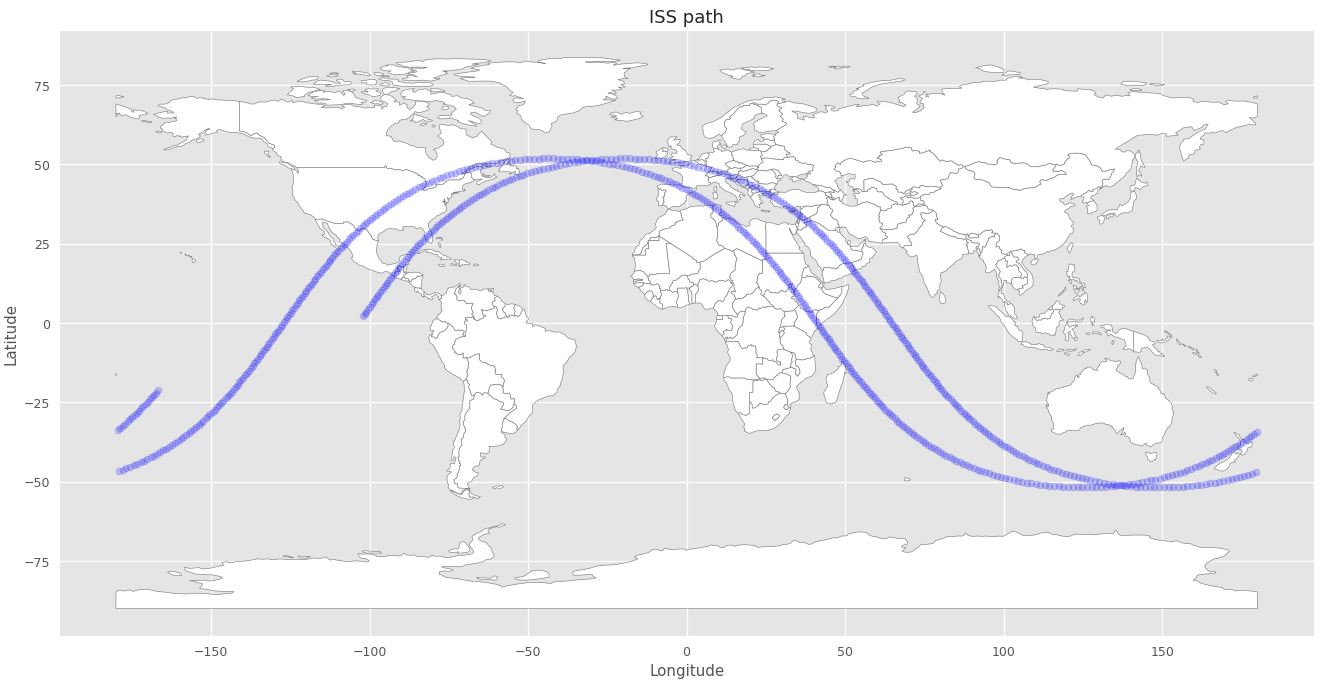

In [7]:
import os
import pandas
import matplotlib.pyplot as plt
import geopandas

file = os.path.join(path_atlantes, RESULTS_FILE)  # CSV input file complete path

data = pandas.read_csv(file)                      # Reading whole file

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10), color="white", edgecolor="grey")
    # Plotting ISS positions (blue)
    plt.scatter(data.longitude, data.latitude, zorder=1, alpha= 0.2, c='blue', s=30)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("ISS path");

The next thing we will do is to locate some interesting points in the dataset. By visualising the pictures and relying on the representation of the points we have made on the world map, we can highlight the following points (we will indicate them with the name of the picture file and the time at which it was captured; all the data correspond to the day 2022-04-26):

|Picture|Hour|Latitude|Longitude|Zone|GMaps|Event|
|:------|:---|:-------|:--------|:---|:----|:----|
|atlantes_047.jpg|08:22:33|35.332735|-72.734483|North Atlantic|[Ver](https://goo.gl/maps/HJTVcULLtXcDaMWy8)|Sunrise|
|atlantes_097.jpg|08:35:03|51.425035|-10.440319|North Atlantic|[Ver](https://goo.gl/maps/skiUxQAnChrhYMd16)|Overflight Ireland begins|
|atlantes_100.jpg|08:35:48|50.963622|-6.056691|North Atlantic|[Ver](https://goo.gl/maps/joS3hY9ZqLv3tzBJ6)|Overflight of Great Britain begins|
|atlantes_104.jpg|08:36:48|50.077849|-0.381559|English Channel|[Ver](https://goo.gl/maps/ajmEkdDD9cj29Ga58)|English Channel; Central European overflight begins|
|atlantes_126.jpg|08:42:18|40.707119|25.72843940|Thracian Sea|[Ver](https://goo.gl/maps/9A6r34vuBb8LTyy87)|Aegean Sea|
|atlantes_127.jpg|08:42:33|40.141351|26.700185|Üçpınar/Lapseki/Province of Çanakkale, Turkey|[Ver](https://goo.gl/maps/uQa7qgcj75gopr8b9)|Turkey overflight begins|
|atlantes_135.jpg|08:44:33|35.318439|33.881839|Yeni İskele|[Ver](https://goo.gl/maps/ofySjbymQZ4nSReg7)|Cyprus|
|atlantes_138.jpg|08:45:18|33.390555|36.333239|Markaz Rif Dimashq District, Siria|[Ver](https://goo.gl/maps/BwUAYNyy6Mf1dQ5B8)|Overflight begins over Arabian Peninsula; Beirut; Damascus|
|atlantes_162.jpg|08:51:18|16.464886|52.604445|Yemen|[Ver](https://goo.gl/maps/VPF497VzHRi4wRD78)|Overflight begins over Arabian Sea and Indian Ocean|
|atlantes_167.jpg|08:52:33|12.726177|55.498419|Arabian Sea|[Ver](https://goo.gl/maps/vTfnVYXSZAd3AinY6)|Socotra Island|
|atlantes_274.jpg|09:19:18|-51.718974|144.575088|Indian Ocean|[Ver](https://goo.gl/maps/k7u6PnwNqHoTd41b7)|Sunset|
|atlantes_419.jpg|09:55:33|35.685683|-95.861464|Twin Hills, Oklahoma, EE. UU.|[Ver](https://goo.gl/maps/jAcH22kuQ3X5QZYSA)|Sunrise|
|atlantes_452.jpg|10:03:48|50.689999|-58.408759|Gulf of St. Lawrence, Canada|[Ver](https://goo.gl/maps/BvpiXAeqmVeMgvdn7)|Gulf of St. Lawrence|
|atlantes_455.jpg|10:04:33|51.233537|-54.068940|North Atlantic|[Ver](https://goo.gl/maps/DusoXsRFbnvkdZwt9)|North Atlantic overflight begins|
|atlantes_492.jpg|10:13:48|43.607322|-3.464841|Cantabrian Sea|[Ver](https://goo.gl/maps/YLnLt1TX8NUeFNP37)|Northern Spain overflight begins|
|atlantes_494.jpg|10:14:18|42.576966|-1.344090|Aibar, 31460, Navarra|[Ver](https://goo.gl/maps/Yq7SUXJmrTeDY2Dt6)|Pamplona, Vitoria, Bilbao|
|atlantes_497.jpg|10:15:03|40.952546|1.698297|Balearic Sea|[Ver](https://goo.gl/maps/Zx9QJcEv2GNR1wje8)|Mediterranean overflight begins|
|atlantes_499.jpg|10:15:33|39.821301|3.637553|Balearic Sea|[Ver](https://goo.gl/maps/jYt6XWt3SzRbd6Hs7)|Balearic Islands|
|atlantes_504.jpg|10:16:48|36.841835|8.197677|Berrihane, Algeria|[Ver](https://goo.gl/maps/vC7SThnWGK2QVbmYA)|Start of North African overflight entering Algeria|
|atlantes_510.jpg|10:18:18|33.024493|13.179739|Mediterranean Sea|[Ver](https://goo.gl/maps/qqueTiqQbNyF6vzs7)|Tripoli|
|atlantes_540.jpg|10:25:48|11.550924|32.783115|Al Renk, South Sudan|[Ver](https://goo.gl/maps/SRjmXCENc54CLtra8)|White Nile|
|atlantes_542.jpg|10:26:18|10.040340|33.902225|Al Mabein, South Sudan|[Ver](https://goo.gl/maps/iDdn4tK7MHCTzr5o6)|Roseires Dam in Blue Nile|
|atlantes_548.jpg|10:27:48|5.482418|37.198316|Guma, Ethiopia|[Ver](https://goo.gl/maps/1Pa9tt73V9w6W6x76)|Lake Abaya|
|atlantes_557.jpg|10:30:03|-1.388801|42.051250|Indian Ocean|[Ver](https://goo.gl/maps/FWVrccxQ6WLkki8F6)|Indian Ocean overflight begins|
|atlantes_567.jpg|10:32:33|-9.002938|47.484864|Indian Ocean|[Ver](https://goo.gl/maps/NuyJ13ddCRA1hA5s5)|Seychelles|
|atlantes_572.jpg|10:33:48|-12.774725|50.282752|Indian Ocean|[Ver](https://goo.gl/maps/E5ZXDmNLpQ1d8LDSA)|Northern Madagascar|
|atlantes_583.jpg|10:36:33|-20.913369|56.806294|Indian Ocean|[Ver](https://goo.gl/maps/SP6g4jnQPmM9cFym9)|Mauritius and Réunion|
|atlantes_646.jpg|10:52:18|-51.747995|121.810786|Indian Ocean|[Ver](https://goo.gl/maps/TZ5E8qRzV6DyZviL7)|Sunset|

We are going to represent the positions of the ISS on the world map again, but this time using different colours to indicate the level of insolation at the time the picture was captured. We will draw the points corresponding to the day phase in orange and the night phase in blue. Our code was able to calculate whether the capture was worth taking because the Earth was receiving sunlight. Thus, we will only have pictures of the orange dots, saving storage space on the blue dots by not capturing the picture, which would have resulted in a completely black image.

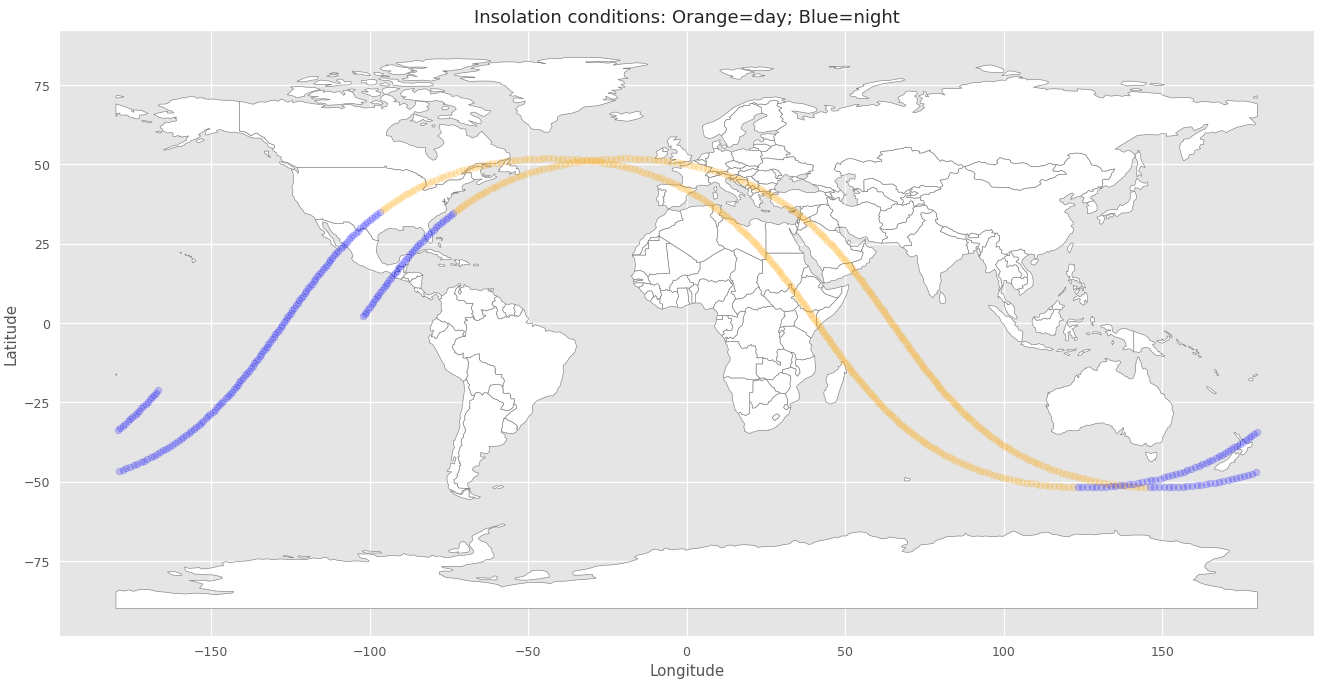

In [8]:
import os
import pandas
import matplotlib.pyplot as plt
import geopandas

file = os.path.join(path_atlantes, RESULTS_FILE)      # CSV input file complete path

dataN1 = pandas.read_csv(file, nrows=46).tail(46)                 # Night 1
dataD1 = pandas.read_csv(file, nrows=274).tail(228)               # Day 1
dataN2 = pandas.read_csv(file, nrows=418).tail(144)               # Night 2
dataD2 = pandas.read_csv(file, nrows=646).tail(228)               # Day 2
dataN3 = pandas.read_csv(file, nrows=713).tail(67)                # Night 3

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10), color="white", edgecolor="grey")
    plt.scatter(dataN1.longitude, dataN1.latitude, zorder=1, alpha= 0.2, c='blue', s=30)
    plt.scatter(dataD1.longitude, dataD1.latitude, zorder=1, alpha= 0.2, c='orange', s=30)
    plt.scatter(dataN2.longitude, dataN2.latitude, zorder=1, alpha= 0.2, c='blue', s=30)
    plt.scatter(dataD2.longitude, dataD2.latitude, zorder=1, alpha= 0.2, c='orange', s=30)
    plt.scatter(dataN3.longitude, dataN3.latitude, zorder=1, alpha= 0.2, c='blue', s=30)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Insolation conditions: Orange=day; Blue=night");

This year the ISS has taken pictures of our country. We are going to represent the overflight over the Iberian Peninsula to locate them.

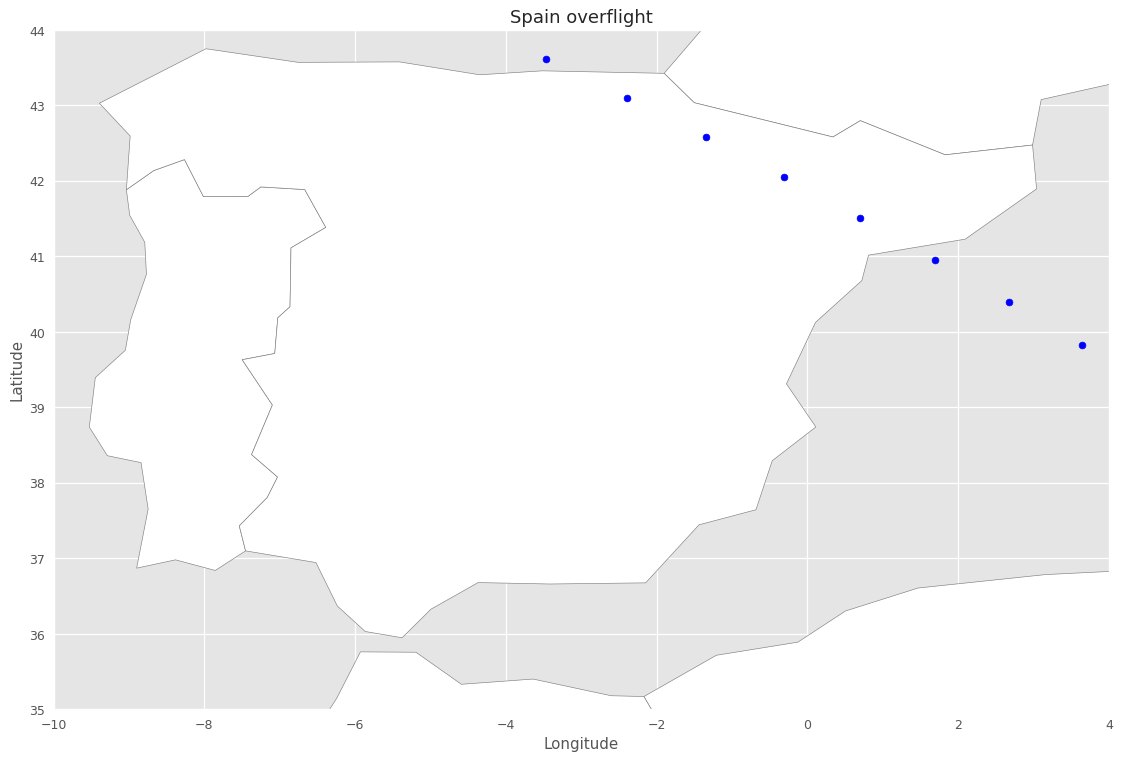

In [9]:
import os
import pandas
import matplotlib.pyplot as plt
import geopandas

file = os.path.join(path_atlantes, RESULTS_FILE)         # CSV input file complete path

data = pandas.read_csv(file, nrows=499).tail(8)          # Reading Spain overflight (492 -> 499)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10), color="white", edgecolor="grey")
    # Plotting ISS positions (blue)
    plt.scatter(data.longitude, data.latitude, zorder=1, alpha= 1, c='blue', s=30)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Spain overflight");
    plt.gca().set_xlim(-10, 4)                           # Setting the longitude limits
    plt.gca().set_ylim(35, 44)                           # Setting the latitude limits

## Chart generation

The CSV file generated in phase 3 by our program executed on board the ISS contains the following columns (and units):

* datetime (AAAA-MM-DD HH:MM:SS)
* picture_file (atlantes_NNN.jpg)
* latitude (º)
* longitude (º)
* elevation (m)
* temp_cpu (ºC)
* temp_h (ºC)
* temp_p (ºC)
* humidity (%)
* pressure (mbar)
* pitch (rad)
* roll (rad)
* yaw (rad)
* mag_x (μT)
* mag_y (μT)
* mag_z (μT)
* accel_x (g)
* accel_y (g)
* accel_z (g)
* gyro_x (rad/s)
* gyro_y (rad/s)
* gyro_z (rad/s)

With all these data we are going to draw graphs to visually decide which of them may be more interesting to represent in Minecraft. During comparisons, two situations can occur:

1. Compare data with the same units, such as `temp_cpu`, `temp_h` y `temp_p`
2. Compare data with different units, such as `temp_cpu` y `mag_x`

In the first case we will draw the classic charts with two coordinate axes, X and Y. In this case we can represent as many columns of data as we want.

In the second case we will make charts with two vertical axes, one on each side of the chart. In this case we can only represent two columns of data.

We are going to see how to make these two types of charts.

### Charts type 1: Data with same units

For example, we are going to plot on the same graph the three temperature measurements obtained by the three different sensors that measure this magnitude installed in AstroPi. The `datetime` column must be converted to Python datetime objects for the charts library to correctly interpret the dates. This is done by specifying the position of the column in the `parse_dates` parameter of the `read_csv()` function.

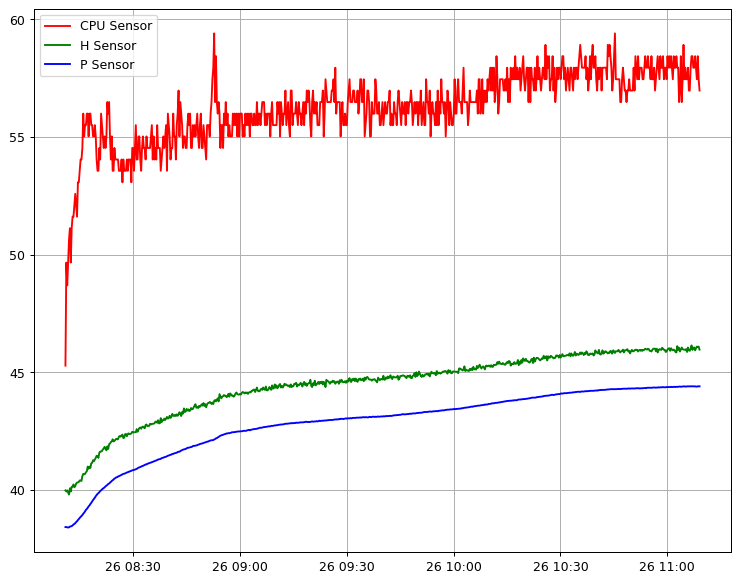

In [10]:
import os
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE)    # CSV input file complete path

data = pandas.read_csv(file, parse_dates=[0])       # Reading whole file

# Columns in file:
#    "datetime", "picture_file", "latitude", "longitude", "elevation", "temp_cpu", "temp_h", "temp_p",
#    "humidity", "pressure", "pitch", "roll", "yaw", "mag_x", "mag_y", "mag_z",
#    "accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"
data_x = data.datetime                        # Data in 'datetime' column
data_y1 = data.temp_cpu                       # Data in 'temp_cpu' column
data_y2 = data.temp_h                         # Data in 'temp_h' column
data_y3 = data.temp_p                         # Data in 'temp_p' column


fig, ax = plt.subplots()                                      # Seting objects to draw with matplotlib
ax.plot(data_x, data_y1, label="CPU Sensor", color="red")     # Plotting 'temp_cpu' against 'datetime'
ax.plot(data_x, data_y2, label="H Sensor", color="green")     # Plotting 'temp_h' against 'datetime'
ax.plot(data_x, data_y3, label="P Sensor", color="blue")      # Plotting 'temp_p' against 'datetime'

plt.legend()                                  # Activating chart legend
plt.grid()                                    # Activating chart grid
plt.show()                                    # Showing the chart

Although it is of no importance for our project, we can already see that the various temperature measurements of the AstroPi Mark II are not very reliable. It seems clear that the heat generated by Raspberry Pi 4 affects these sensors a lot.

### Charts type 2: Data with different units

To illustrate this case we will plot for example the data columns `temp_p` (left axis) and `pressure` (right axis) against time (thanks to [this article](https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/) for the example).

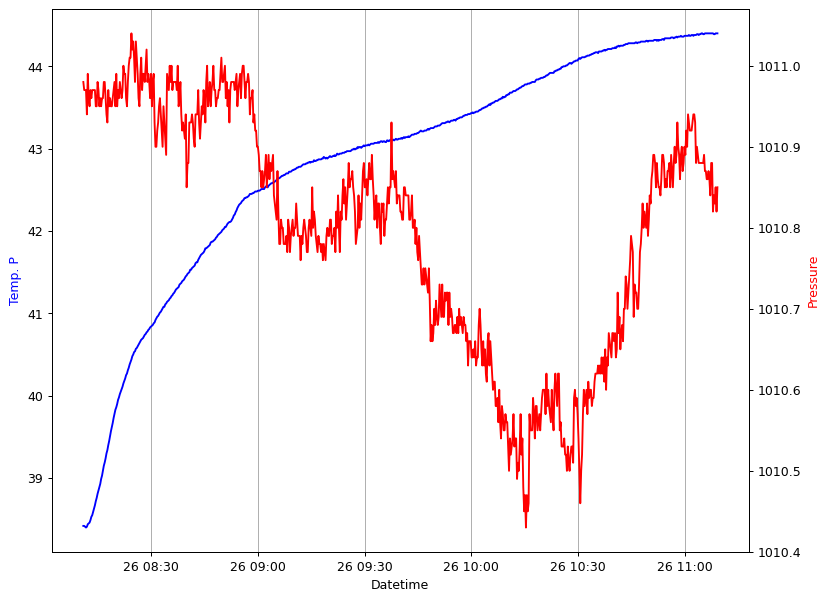

In [11]:
import os
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE)    # CSV input file complete path

data = pandas.read_csv(file, parse_dates=[0])       # Reading whole file

# Columns in file:
#    "datetime", "picture_file", "latitude", "longitude", "elevation", "temp_cpu", "temp_h", "temp_p",
#    "humidity", "pressure", "pitch", "roll", "yaw", "mag_x", "mag_y", "mag_z",
#    "accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"

data_x = data.datetime                        # Data in 'datetime' column
data_y1 = data.temp_p                         # Data in 'temp_p' column
data_y2 = data.pressure                       # Data in 'pressure' column

fig, ax = plt.subplots()                      # Seting objects to draw with matplotlib
ax.set_xlabel('Datetime')                     # Setting X axis legend

ax.plot(data_x, data_y1, color="blue")        # Plotting 'temp_p' against 'datetime' in blue
ax.set_ylabel('Temp. P', color="blue")        # Setting Y axis legend

ax2 = ax.twinx()                              # Creating new vertical axis
ax2.plot(data_x, data_y2, color="red")        # Plotting 'pressure' against 'datetime' in red
ax2.set_ylabel("Pressure", color="red")       # Setting second Y axis legend

ax.grid(axis='x')                             # Activating chart grid
plt.show()                                    # Showing the chart

If we need to compare more than two different data series, we still have an option, which is to place the series on top of each other in different graphs with the horizontal axis coinciding. For example:

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

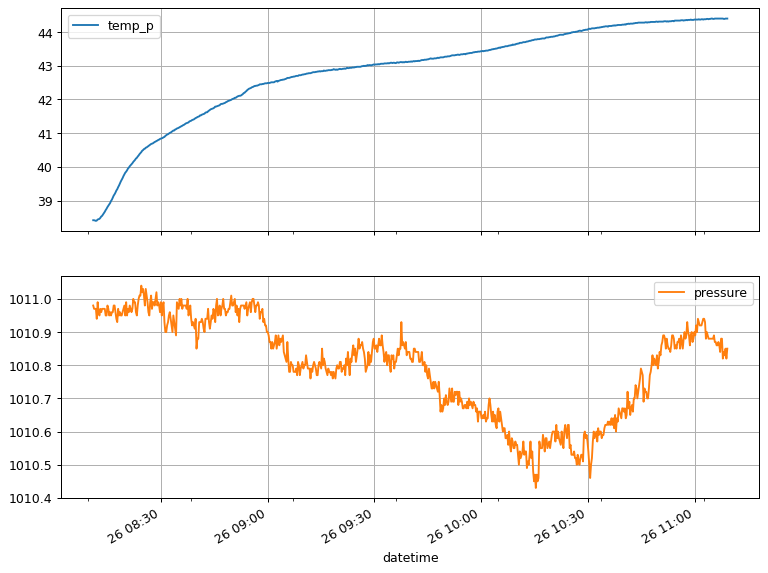

In [12]:
import os
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE)    # CSV input file complete path

# We read the whole file indicating the column that will act as a common index for all the data
data = pandas.read_csv(file, parse_dates=[0], index_col='datetime')

data[['temp_p', 'pressure']].plot(subplots=True, grid=True)

With these representation techniques we will be able to analyse the data in order to identify the best data sets for gamification.

## Charts in Minecraft

The first thing we tried to do is to draw some of the graphs of the data we learned to do with `matplotlib` inside a Minecraft world.

We wanted to use the Minecraft Pi version of the game because it has the following advantages:

* It runs on Raspberry Pi.
* It does not require a paid licence to experiment with it, which would have been a problem for students.
* It implements by default the [mcpi](https://github.com/martinohanlon/mcpi) library that allows to manipulate the game from Python code.

### Minecraft: Pi Edition: Reborn

Unfortunately the official version of Minecraft Pi was not yet available for the `Bullseye` version of Raspbian OS which is the system we had started using on Raspberry Pi before starting the project. We found an alternative that works very similarly called [Minecraft: Pi Edition: Reborn](https://github.com/MCPI-Revival/minecraft-pi-reborn) which worked very well. Although to run it on a Linux x86 PC we had to stick with version 2.3.3, as the last version (2.3.11) gave us an error.

When we open the Reborn version of Minecraft Pi we are presented with a series of options dialogue boxes. We will use the following options:

![Minecraft Pi - Options 1](https://niubit.net/media/uploads/images/atlantes_2021-2022/mcpi_options_1.png)

![Minecraft Pi - Options 2](https://niubit.net/media/uploads/images/atlantes_2021-2022/mcpi_options_2.png)

### API Minecraft Pi

The API for the `mcpi` library can be found at [this page](https://www.stuffaboutcode.com/p/minecraft-api-reference.html) by one of the authors of the fantastic book [Adventures in Minecraft](www.wiley.com/buy/9781118946916) that teaches how to manipulate Minecraft worlds with Python code through different projects very similar to ours.

For a Python program to connect to the backend inside Minecraft Pi to listen to `mcpi` API calls, just do the following:

```python
from mcpi import minecraft
from mcpi import block

mc = minecraft.Minecraft.create()
```

On the `mc` object we will invoke most of the [API](https://www.stuffaboutcode.com/p/minecraft-api-reference.html) calls. For example to create a wood block at the Minecraft position (20, 4, 20) we will do:

```python
mc.setBlock(20, 4, 20, block.WOOD.id)
```

If we approach that position, we should see something like the following:

![setBlock call](https://niubit.net/media/uploads/images/atlantes_2021-2022/setBlock.png)

### Matplotlib - Minecraft Backend

Early on in our research into the possibilities of Minecraft to host our graphics, we discovered [this library](https://github.com/PetarMihalj/Matplotlib-Minecraft-Backend) that implements a backend for `matplotlib` inside Minecraft. It was one of the ideas we originally had, so finding out that it was already done made us look for other targets.

Before we start with the new objectives, let's take a brief look at the possibilities of this library. The library accompanies this notebook in the repository, so we will be able to use it without installing it.

We start by plotting the graph of the temperature detected by the pressure sensor versus time. We achieve this with the following code. For some reason, probably bugs in the backend code, we have to restart the Jupyter kernel every time we want to generate the graph. The following code can't be executed in Google Colab as commented at the beginning of the notebook:

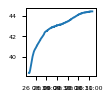

In [13]:
import os
import pandas
from mc_mpl.mde import MDE
import matplotlib.pyplot as plt
import matplotlib as mpl
from mcpi import minecraft
from mcpi import block

# Constants
IMAGE_WIDTH = 256
IMAGE_POS_X = -144
IMAGE_POS_Z = -138
MAX_HEIGHT = 32

mpl.use("module://mc_mpl.mc_backend")

mc = minecraft.Minecraft.create()

# Creating flat world
# https://github.com/brooksc/mcpipy/blob/master/mcpi/examples/snowbound_flatmap.py
mc.setBlocks(IMAGE_POS_X, 0, IMAGE_POS_Z, IMAGE_POS_X+IMAGE_WIDTH, 64, IMAGE_POS_Z+IMAGE_WIDTH, block.AIR.id)
mc.setBlocks(IMAGE_POS_X, 0, IMAGE_POS_Z, IMAGE_POS_X+IMAGE_WIDTH, -64, IMAGE_POS_Z+IMAGE_WIDTH, block.SANDSTONE.id)

file = os.path.join(path_atlantes, RESULTS_FILE)    # CSV input file complete path
data = pandas.read_csv(file, parse_dates=[0])       # Reading whole file

# Columns in file:
#    "datetime", "picture_file", "latitude", "longitude", "elevation", "temp_cpu", "temp_h", "temp_p",
#    "humidity", "pressure", "pitch", "roll", "yaw", "mag_x", "mag_y", "mag_z",
#    "accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"

data_x = data.datetime                   # Data in 'datetime' column
data_y1 = data.temp_p                    # Data in 'temp_p' column

# Plotting chart
plt.plot(data_x, data_y1)
plt.show()

# We position the player over the graph
mc.player.setPos(-44, 68, 44)

We should see something similar if we look down from the position where the code places us:

![Temp P in Minecraft](https://niubit.net/media/uploads/images/atlantes_2021-2022/temp_p_in_minecraft.png)

If we go down and stand on the chart we will have fulfilled the objective we set ourselves with this project, i.e. "walking on the data":

![Walking over Temp P in Minecraft](https://niubit.net/media/uploads/images/atlantes_2021-2022/temp_p_in_minecraft_walking.png)

## NDVI analysis

Having solved "too easily" the goal of representing data graphs in Minecraft and walking on them, thanks to the [Matplotlib - Minecraft Backend](https://github.com/PetarMihalj/Matplotlib-Minecraft-Backend) library, we started to think about other types of graphs to exploit in Minecraft virtual worlds. We immediately focused on pictures, as they are the most eye-catching of all the data captured by the code running in Phase 3 at the station. Also, as we mentioned at the beginning of the notebook, this year we chose the Astro Pi with IR camera instead of the VIS, to test the performance of the new Mark II hardware without relying too much on the accuracy of the samples. The idea that came out of our team's brainstorming sessions was to choose some pictures, colour them with the typical colour scales that are usually used to represent this index and finally convert the coloured pixels of the pictures to coloured wool blocks in Minecraft. Minecraft's wool blocks only support 16 different colours, so the NDVI conversions of the pictures will not only lose pixel resolution, they will also lose colour resolution, although this seems appropriate in the game's low-resolution graphics rendering scheme.

Before working out how to translate the pictures converted to NDVI and coloured with a scale, we first looked at what NDVI is and how the pictures can be worked with in Python to perform the calculations. The document that guided us in general was [Capture plant health with NDVI and Raspberry Pi](https://projects.raspberrypi.org/en/projects/astropi-ndvi/) from the Raspberry Pi Foundation. We will not repeat here the explanations given in the aforementioned guide; suffice it to say that the index is obtained with a simple arithmetic operation applied to all the pixels of the pictures (specifically the one that can be seen in the `calc_ndvi` function below). To easily perform the calculations on all the pixels, we take advantage of the facility offered by the [OpenCV](https://opencv.org/) library to work with multidimensional data arrays. Following the guide and adapting the code to our tastes and needs, we arrive at the definition of a series of functions that we will use in the following:

In [14]:
import cv2
import numpy as np

def display(image, image_name):
    image = np.array(image, dtype=float)/float(255)
    cv2.namedWindow(image_name)
    cv2.imshow(image_name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def contrast_stretch(im, percentile=True):
    if percentile:
        in_min = np.percentile(im, 5)
        in_max = np.percentile(im, 95)
    else:
        in_min = float(np.min(im))
        in_max = float(np.max(im))
    
    out_min = 0.0
    out_max = 255.0
    
    out = im - in_min
    out *= ((out_min - out_max) / (in_min - in_max))
    out += in_min
    
    return out

def scale_to_int(im):
    out = im + 1
    out *= 127.5
    out += -1
    return np.array(np.rint(out), dtype=int).clip(0,255)

def calc_ndvi(image):
    b, g, r = cv2.split(image)
    bottom = (b.astype(float) + r.astype(float))
    bottom[bottom==0] = 0.01
    ndvi = (b.astype(float) - r) / bottom
    return ndvi

### fastiecm map

The colour mapping we will do of the pictures converted to NDVI will be done with the `fastiecm` scale described in [this document](https://publiclab.org/notes/cfastie/08-26-2014/new-ndvi-colormap) and which can be found [here](https://storage.googleapis.com/publiclab-production/public/system/images/photos/000/006/146/original/NDVI_VGYRM-lut.txt). A graphical representation of the full gradient of NDVI values (from -1 to +1) would be as follows:

![fastiecm look up table](https://niubit.net/media/uploads/images/atlantes_2021-2022/NDVI_VGYRM_lutA.jpg)

The `fastiecm` library that will be imported in successive code blocks is linked in the fifth page of the guide [Capture plant health with NDVI and Raspberry Pi](https://projects.raspberrypi.org/en/projects/astropi-ndvi/5), specifically it can be obtained from [this link](https://projects-static.raspberrypi.org/projects/astropi-ndvi/5259003bfcc5a4a54c3340a04e124502a1466511/en/images/fastiecm.py). It is embedded in the files used to run this notebook, so it can be imported directly as we will see in the code. This library is basically a conversion of the table [fastiecm](https://storage.googleapis.com/publiclab-production/public/system/images/photos/000/006/146/original/NDVI_VGYRM-lut.txt) to a 256-element Python list. It is important to note that internally the colours are mapped in BGR scale, not RGB like the [scale in text format](https://storage.googleapis.com/publiclab-production/public/system/images/photos/000/006/146/original/NDVI_VGYRM-lut.txt). That is, the positions of the red and blue channels are swapped. This is because the operations with the pixel colours of the pictures will be done with the Python OpenCV library, which handles the colour information in this format.

The table has greyscale elements from position 0 to 136 inclusive. Between 137 and 255 are colours. The scale initially makes several gradients between black and white before it starts to take on colour. This is because values below 0 are considered to imply lifeless matter and above 0 with it. So it is not worth colouring the negative area and if several gradients are made it is so that the areas of lifeless matter have more detail in the final representation.

### fastiecm map test

We are going to test the functions defined in the previous block by trying to calculate the NDVI of a picture and mapping the values to the `fastiecm` scale. As we have not modified the camera of our Astro Pi Mark II kit, we are going to use a picture from the set provided by ESA earlier this year after the deployment of the new Astro Pi on the space station, specifically this one that appears to contain crop fields:

![photo_01080_51845638376](https://niubit.net/media/uploads/images/atlantes_2021-2022/photo_01080_51845638376.jpg)

The code that will do the conversion based on the above functions is as follows:

In [15]:
import cv2
from fastiecm import fastiecm

# Constants
IMAGE_WIDTH = 800

file_in = os.path.join(path_images, 'photo_01080_51845638376.jpg')
image = cv2.imread(file_in)
image_w = image.shape[1]
image_h = image.shape[0]
scaled_width = IMAGE_WIDTH
scaled_height = round(image_h*scaled_width/image_w)
image_scaled = cv2.resize(image, (scaled_width, scaled_height))
ndvi = calc_ndvi(image_scaled)
ndvi_int = scale_to_int(ndvi).astype(np.uint8)
ndvi_color = cv2.applyColorMap(ndvi_int, fastiecm)
file_out = os.path.join(path_images, 'test_fastiecm.jpg')
cv2.imwrite(file_out, ndvi_color)

True

And this is the result:

![](https://niubit.net/media/uploads/images/atlantes_2021-2022/test_fastiecm.jpg)

Now that we know how to handle the NDVI in the conventional way, let's try to bring it into the Minecraft universe.

### Conversion of `fastiecm` map to wool colours Minecraft

As mentioned above, in Minecraft we are going to use coloured wool blocks (ID: 35) that offer 16 possible values. The sequence of these blocks in the natural order, i.e. with their colour IDs from 0 to 15, is as follows:

![Wool color sequence](https://niubit.net/media/uploads/images/atlantes_2021-2022/wool_color_scale.png)

The first thing to do is to convert these colours to RGB. In [this forum](https://gaming.stackexchange.com/questions/47212/what-are-the-color-values-for-dyed-wool) the following values are suggested:

In [16]:
wool_rgb = [[0xe4,0xe4,0xe4],   #  0: WOOL_WHITE
            [0xea,0x7e,0x35],   #  1: WOOL_ORANGE
            [0xbe,0x49,0xc9],   #  2: WOOL_MAGENTA
            [0x63,0x87,0xd2],   #  3: WOOL_LIGHT_BLUE
            [0xc2,0xb5,0x1c],   #  4: WOOL_YELLOW
            [0x39,0xba,0x2e],   #  5: WOOL_LIME
            [0xd9,0x81,0x99],   #  6: WOOL_PINK
            [0x41,0x41,0x41],   #  7: WOOL_GRAY
            [0xa0,0xa7,0xa7],   #  8: WOOL_LIGHT_GRAY
            [0x26,0x71,0x91],   #  9: WOOL_CYAN
            [0x7e,0x34,0xbf],   # 10: WOOL_PURPLE
            [0x25,0x31,0x93],   # 11: WOOL_BLUE
            [0x56,0x33,0x1c],   # 12: WOOL_BROWN
            [0x36,0x4b,0x18],   # 13: WOOL_GREEN
            [0x9e,0x2b,0x27],   # 14: WOOL_RED
            [0x18,0x14,0x14]]   # 15: WOOL_BLACK

The same table in BGR format which will be the format we will use in the code using the OpenCV library and the `fastiecm` module is:

In [17]:
wool_bgr = [[0xe4,0xe4,0xe4],   #  0: WOOL_WHITE
            [0x35,0x7e,0xea],   #  1: WOOL_ORANGE
            [0xc9,0x49,0xbe],   #  2: WOOL_MAGENTA
            [0xd2,0x87,0x63],   #  3: WOOL_LIGHT_BLUE
            [0x1c,0xb5,0xc2],   #  4: WOOL_YELLOW
            [0x2e,0xba,0x39],   #  5: WOOL_LIME
            [0x99,0x81,0xd9],   #  6: WOOL_PINK
            [0x41,0x41,0x41],   #  7: WOOL_GRAY
            [0xa0,0xa7,0xa7],   #  8: WOOL_LIGHT_GRAY
            [0x91,0x71,0x26],   #  9: WOOL_CYAN
            [0xbf,0x34,0x7e],   # 10: WOOL_PURPLE
            [0x93,0x31,0x25],   # 11: WOOL_BLUE
            [0x1c,0x33,0x56],   # 12: WOOL_BROWN
            [0x18,0x4b,0x36],   # 13: WOOL_GREEN
            [0x27,0x2b,0x9e],   # 14: WOOL_RED
            [0x18,0x14,0x14]]   # 15: WOOL_BLACK

The greyscale colours in the above table ordered from white to black are:

* 0: WOOL_WHITE
* 8: WOOL_LIGHT_GRAY
* 7: WOOL_GRAY
* 15: WOOL_BLACK

The rest we will try to map with a small algorithm that locates the nearest colour from the `fastiecm` table.

In [18]:
def search_wool_color(color, bw=True):
    min = 256*3
    min_index = 0
    for i in range(16):
        if bw:
            if i in [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14]:
                continue
        else:
            if i in [0, 7, 8, 15]:
                continue
        test_min = abs(color[0] - wool_bgr[i][0]) + abs(color[1] - wool_bgr[i][1]) + abs(color[2] - wool_bgr[i][2])
        if test_min < min:
            min = test_min
            min_index = i
    return min_index

wool_map = []
for index, color in enumerate(fastiecm):
    if index in range(0, 137):
        wool_color = search_wool_color(color[0], bw=True)
    else:
        wool_color = search_wool_color(color[0], bw=False)
    
    wool_map.append(wool_color)

fastiecm_wool = []
for i in wool_map:
    fastiecm_wool.append(wool_bgr[i])
image = np.array([fastiecm_wool])
file_out = os.path.join(path, 'draw_fastiecm_wool.png')
cv2.imwrite(file_out, image)
print(wool_map)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 13, 13, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1, 1, 1, 1, 6, 6, 6, 2, 2, 2, 2, 2]


The list produced by the above code represents the index of the nearest wool colours of the 256 positions in the `fastiecm` table. In the above code we have dumped the colour sequence into a png file so that we can compare it with the conventional `fastiecm`. Representing the `fastiecm` colours next to those of the wool in the position we just obtained we find the following:

![](https://niubit.net/media/uploads/images/atlantes_2021-2022/NDVI_wool_first_version.png)

As we can see, the algorithm has worked quite well, but it does some irregularities such as introducing orange before and after red, when there should only be orange before. By manually correcting the irregularities at our discretion, we arrive at the following correspondence:

![](https://niubit.net/media/uploads/images/atlantes_2021-2022/NDVI_wool_fixed_version.png)

Converting the list obtained in the previous code block and corrected afterwards into a Numpy array with the same dimensions as used in the `fastiecm` module used in conventional NDVI colourings, we obtain:

In [19]:
fastiecm_wool_index = np.array([[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [8],
                                [8], [8], [8], [8], [8], [8], [8], [8], [8], [8], [8], [8], [8], [8], [8],
                                [8], [8], [8], [8], [7], [7], [7], [7], [7], [7], [7], [7], [7], [7], [7],
                                [7], [7], [7], [7], [7], [7], [7], [7], [7], [7], [7], [7], [7], [7], [7],
                                [7], [7], [7], [8], [8], [8], [8], [8], [8], [8], [8], [8], [8], [8], [8],
                                [8], [8], [8], [8], [8], [8], [8], [8], [0], [0], [0], [0], [0], [0], [0],
                                [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0],
                                [0], [0], [0], [8], [8], [8], [8], [8], [8], [8], [8], [8], [8], [8], [8],
                                [8], [8], [8], [8], [8], [7], [7], [7], [7], [7], [7], [7], [7], [7], [7],
                                [7], [7], [9], [9], [9], [9], [3], [3], [3], [3], [3], [3], [3], [3], [3],
                                [3], [3], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5],
                                [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [4], [4], [4], [4], [4],
                                [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4],
                                [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4],
                                [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],
                                [1], [1], [1], [1], [1], [14], [14], [14], [14], [14], [14], [14], [14],
                                [14], [14], [14], [14], [14], [14], [14], [14], [14], [14], [2], [2], [2],
                                [2], [2], [2], [2], [2]], dtype=np.uint8)

Replacing the index with BGR colours from the `wool_bgr` list we get another array that will be equivalent to the original `fastiecm` but with Minecraft colours. We don't show the array here as it is quite large, but it can be found in the `fastiecm_wool.py` module that accompanies this notebook. The difference between the two arrays is:

* `fastiecm_wool_index`: We will use it when we want to generate coloured blocks in Minecraft worlds from pictures, as it will indicate the ID of the colour of wool to use.
* `fastiecm_wool`: We will use it when we want to generate colour mapped pictures, but using the Minecraft colours instead of the original `fastiecm` table. It will help us to have an image that we will compare with the result obtained inside Minecraft, to see if we are doing things right.

To test the new colour tables with the Minecraft wool colours, let's convert the same picture from the previous subsection, but using the `fastiecm_wool` table this time:

In [20]:
import cv2
from fastiecm_wool import fastiecm_wool

# Constantes
IMAGE_WIDTH = 800

file_in = os.path.join(path_images, 'photo_01080_51845638376.jpg')
image = cv2.imread(file_in)
image_w = image.shape[1]
image_h = image.shape[0]
scaled_width = IMAGE_WIDTH
scaled_height = round(image_h*scaled_width/image_w)
image_scaled = cv2.resize(image, (scaled_width, scaled_height))
ndvi = calc_ndvi(image_scaled)
ndvi_int = scale_to_int(ndvi).astype(np.uint8)
ndvi_color = cv2.applyColorMap(ndvi_int, fastiecm_wool)
file_out = os.path.join(path_images, 'test_fastiecm_wool.jpg')
cv2.imwrite(file_out, ndvi_color)

True

This is the result:

![](https://niubit.net/media/uploads/images/atlantes_2021-2022/test_fastiecm_wool.jpg)

As we can see the colouring corresponds quite well, as we have already seen in the comparative scales we have shown before, but there is a loss of detail (especially in the greyscale areas).

The picture above should correspond quite well with what we will see later in Minecraft.

### Proof of concept in Minecraft

We already know how to use the Minecraft Pi API, do picture to NDVI conversions and map those values to wool block colour codes, so by putting all these pieces together we should already be able to, for example, draw an NDVI picture in Minecraft. Let's try this based on the picture we used when we talked about NDVI earlier.

The following code will do the magic. For it to work, Minecraft Pi (or the `Minecraft: Pi Edition: Reborn` version we use) must be running with an open world on the same computer where this notebook is run (this unfortunately cannot be done through Google Colab; for this reason we will post screenshots and/or videos of the results in this notebook). The outline of the code is as follows:

1. Importing modules
2. Definition of useful constants
3. Crop and scale the picture to 256x256 px as these are the dimensions of the worlds in Minecraft Pi
4. Deletion of all blocks in the world and creation of a stone plane at level 0
5. NDVI calculation of the cropped and scaled picture and conversion to Minecraft wool values
6. Creation of the wool blocks

In [21]:
import cv2
import numpy as np
from fastiecm_wool import fastiecm_wool_index
from mcpi import minecraft
from mcpi import block

# Constants
IMAGE_WIDTH = 256
IMAGE_POS_X = -144
IMAGE_POS_Z = -138

# Crop and scale the image to 256x256 px
file_in = os.path.join(path_images, 'photo_01080_51845638376.jpg')
image = cv2.imread(file_in)
image_cropped = image[10:2890,800:3680]                   # Crop the windowed area
image_w = image_cropped.shape[1]
image_h = image_cropped.shape[0]
scaled_width = IMAGE_WIDTH                                # 256
scaled_height = round(image_h*scaled_width/image_w)       # 256
image_scaled = cv2.resize(image_cropped, (scaled_width, scaled_height))

mc = minecraft.Minecraft.create()

# Creating flat world
# https://github.com/brooksc/mcpipy/blob/master/mcpi/examples/snowbound_flatmap.py
mc.setBlocks(IMAGE_POS_X, 0, IMAGE_POS_Z, IMAGE_POS_X+scaled_width, 64, IMAGE_POS_Z+scaled_height, block.AIR.id)
mc.setBlocks(IMAGE_POS_X, 0, IMAGE_POS_Z, IMAGE_POS_X+scaled_width, -64, IMAGE_POS_Z+scaled_height, block.SANDSTONE.id)

ndvi = calc_ndvi(image_scaled)
ndvi_int = scale_to_int(ndvi)
ndvi_int_prep = ndvi_int.astype(np.uint8)
ndvi_color_wool = cv2.LUT(ndvi_int_prep, fastiecm_wool_index)

for z in range(len(ndvi_color_wool)):
    for x in range(len(ndvi_color_wool[z])):
        mc.setBlock(x+IMAGE_POS_X, 10, z+IMAGE_POS_Z, block.WOOL.id, ndvi_color_wool.item(z, x))

mc.player.setPos(-15,174,-10)

What we see, after waiting a few minutes for Minecraft to update all the newly created blocks in the game window and pressing F1 to hide the toolbox, is the following:

![](https://niubit.net/media/uploads/images/atlantes_2021-2022/mc-fastiecm_wool.png)

As we can see it corresponds perfectly with the picture we had obtained by doing the conventional NDVI analysis and using the `fastiecm_wool` scale we have calculated in the previous sections.

## Results

Now that we have mastered the technique, let's apply it to the pictures captured this year in Phase 3.

### NDVI conversion

The first thing to do is to convert all the pictures to NDVI scale coloured with the `fastiecm` table. We do this with the following code which relies on some of the functions defined above:

In [22]:
import os

# Constants
IMAGE_WIDTH = 800

dest_dir = os.path.join(path, 'atlantes_ndvi')

for subdir, dirs, files in os.walk(path_atlantes):
    for file in files:
        if file.endswith('jpg'):
            image = cv2.imread(os.path.join(subdir, file))
            image_w = image.shape[1]
            image_h = image.shape[0]
            scaled_width = IMAGE_WIDTH
            scaled_height = round(image_h*scaled_width/image_w)
            image_scaled = cv2.resize(image, (scaled_width, scaled_height))
            ndvi = calc_ndvi(image_scaled)
            ndvi_int = scale_to_int(ndvi)
            ndvi_int_prep = ndvi_int.astype(np.uint8)
            ndvi_color = cv2.applyColorMap(ndvi_int_prep, fastiecm)
            cv2.imwrite(os.path.join(dest_dir, file), ndvi_color)

### Selection of pictures

Before we continue, let us choose a few of the 456 pictures captured by Astro Pi IR during the execution of our code on 26 April 2022, which have an interesting NDVI representation. It must be said that in general we do not seem to have had very good luck this year with the pictures obtained, neither in visible nor in NDVI. Our selection is as follows:

|Picture|Hour|Latitude|Longitude|Zone|GMaps|
|:------|:---|:-------|:--------|:---|:----|
|atlantes_098.jpg|08:35:18|51.291040|-8.968631|Southern Ireland|[Ver](https://goo.gl/maps/ynapD4Y6yoAgyv7h8)|
|atlantes_101.jpg|08:36:03|50.770510|-4.617049|Bristol Channel|[Ver](https://goo.gl/maps/vNSLhW1VEBCZ4HEo7)|
|atlantes_157.jpg|08:50:03|20.151184|49.586329|Rub al-Jali desert, Arabian Peninsula|[Ver](https://goo.gl/maps/NmBYBLFbSdBQ4sJ78)|
|atlantes_494.jpg|10:14:18|42.576966|-1.344090|Pamplona, Vitoria, Bilbao|[Ver](https://goo.gl/maps/PyGFhTSwGvQ41pqG9)|
|atlantes_499.jpg|10:15:33|39.821301|3.637553|Balearic Islands|[Ver](https://goo.gl/maps/bEaEeU9sJtKUkoQD8)|
|atlantes_583.jpg|10:36:33|-20.913369|56.806294|Mauritius and Réunion (the clouds and the volcano of Reunion can be seen in NDVI)|[Ver](https://goo.gl/maps/PtK24tEdy1LnaJpq6)|

* 098 - Southern Ireland:

    ![Southern Ireland](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_098.jpg) ![Southern Ireland NDVI](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_098_ndvi.jpg)


* 101 - Bristol Channel:

    ![Bristol Channel](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_101.jpg) ![Bristol Channel NDVI](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_101_ndvi.jpg)


* 157 - Rub al-Jali desert:

    ![Rub al-Jali desert](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_157.jpg) ![Rub al-Jali desert NDVI](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_157_ndvi.jpg)


* 494 - Pamplona, Vitoria, Bilbao:

    ![Pamplona, Vitoria, Bilbao](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_494.jpg) ![Pamplona, Vitoria, Bilbao NDVI](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_494_ndvi.jpg)


* 499 - Balearic Islands:

    ![Balearic Islands](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_499.jpg) ![Balearic Islands NDVI](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_499_ndvi.jpg)


* 583 - Mauritius and Réunion:

    ![Mauritius and Réunion](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_583.jpg) ![Mauritius and Réunion NDVI](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_583_ndvi.jpg)

Special mention for picture 495 which includes our city, Zaragoza. Although again we were unlucky and the clouds did not allow us to appreciate details of the city. We include below a cropped and enlarged representation of this picture on which we have labelled some points of interest.

![Zaragoza and surroundings](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_495_zaragoza.jpg)

### Representation in Minecraft

In order not to repeat the same thing 6 times with the 6 selected pictures, we are going to work in Minecraft with only one of them. The number 157 of the Rub al-Jali Desert was selected as an example of how well the NDVI analysis works, but as we do the creation of blocks in Minecraft, it would be a completely grey world. The picture chosen to work with is the 101 that captures the Bristol Channel. The code to represent the picture in NDVI format with our `fastiecm_wool` colour scale will be the same as we saw above, except for adapting the path of the picture. This time we are going to include the code that crops the part bounded by the window of the station from which the picture was taken, also leaving a square format picture, so that it fits better in the 256x256 square world of Minecraft:

In [23]:
import cv2
import numpy as np
from fastiecm_wool import fastiecm_wool_index

# Constants
IMAGE_WIDTH = 800

# Crop and scale the image to 800x800 px
file_in = os.path.join(path_atlantes, 'atlantes_101.jpg')
image = cv2.imread(file_in)
image_cropped = image[140:2464,560:2884]                  # Crop of the window area
image_w = image_cropped.shape[1]
image_h = image_cropped.shape[0]
scaled_width = IMAGE_WIDTH                                # 800
scaled_height = round(image_h*scaled_width/image_w)       # 800
image_scaled = cv2.resize(image_cropped, (scaled_width, scaled_height))

ndvi = calc_ndvi(image_scaled)
ndvi_int = scale_to_int(ndvi).astype(np.uint8)
ndvi_color = cv2.applyColorMap(ndvi_int, fastiecm_wool)
file_out = os.path.join(path_images, 'atlantes_101_ndvi_wool.jpg')
cv2.imwrite(file_out, ndvi_color)

True

![Bristol Channel NDVI fastiecm_wool](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_101_ndvi_wool.jpg)

The code to draw the picture in Minecraft Pi will be as follows (again does not work in Google Colab):

In [24]:
import cv2
import numpy as np
from fastiecm_wool import fastiecm_wool_index
from mcpi import minecraft
from mcpi import block

# Constants
IMAGE_WIDTH = 256
IMAGE_POS_X = -144
IMAGE_POS_Z = -138

# Crop and scale the image to 256x256 px
file_in = os.path.join(path_atlantes, 'atlantes_101.jpg')
image = cv2.imread(file_in)
image_cropped = image[140:2464,560:2884]                  # Crop of the window area
image_w = image_cropped.shape[1]
image_h = image_cropped.shape[0]
scaled_width = IMAGE_WIDTH                                # 256
scaled_height = round(image_h*scaled_width/image_w)       # 256
image_scaled = cv2.resize(image_cropped, (scaled_width, scaled_height))

mc = minecraft.Minecraft.create()

# Creating flat world
# https://github.com/brooksc/mcpipy/blob/master/mcpi/examples/snowbound_flatmap.py
mc.setBlocks(IMAGE_POS_X, 0, IMAGE_POS_Z, IMAGE_POS_X+scaled_width, 64, IMAGE_POS_Z+scaled_height, block.AIR.id)
mc.setBlocks(IMAGE_POS_X, 0, IMAGE_POS_Z, IMAGE_POS_X+scaled_width, -64, IMAGE_POS_Z+scaled_height, block.SANDSTONE.id)

ndvi = calc_ndvi(image_scaled)
ndvi_int = scale_to_int(ndvi)
ndvi_int_prep = ndvi_int.astype(np.uint8)
ndvi_color_wool = cv2.LUT(ndvi_int_prep, fastiecm_wool_index)

for z in range(len(ndvi_color_wool)):
    for x in range(len(ndvi_color_wool[z])):
        mc.setBlock(x+IMAGE_POS_X, 10, z+IMAGE_POS_Z, block.WOOL.id, ndvi_color_wool.item(z, x))

mc.player.setPos(-15,174,-10)

And this is the result:

![Atlantes 101 - NDVI Minecraft](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_101_ndvi_wool_minecraft.png)

### Representation in Minecraft with relief

We are going to represent picture 101 again, but this time we will encode the NDVI index with relief instead of with colour as we have done before. We will assimilate Minecraft level 0 with NDVI 0. Negative values will not be represented. Thus, lifeless areas will be seen as flat ground (level 0 in Minecraft) and everything that protrudes above the horizon will correspond to living matter. The +1 value of the NDVI index will correspond to height 32.

The code that achieves this is as follows (again does not work in Google Colab):

In [25]:
import cv2
import numpy as np
from mcpi import minecraft
from mcpi import block

# Constants
IMAGE_WIDTH = 256
IMAGE_POS_X = -144
IMAGE_POS_Z = -138
MAX_HEIGHT = 32

# Crop and scale the image to 256x256 px
file_in = os.path.join(path_atlantes, 'atlantes_101.jpg')
image = cv2.imread(file_in)
image_cropped = image[140:2464,560:2884]                  # Crop of the window area
image_w = image_cropped.shape[1]
image_h = image_cropped.shape[0]
scaled_width = IMAGE_WIDTH                                # 256
scaled_height = round(image_h*scaled_width/image_w)       # 256
image_scaled = cv2.resize(image_cropped, (scaled_width, scaled_height))

mc = minecraft.Minecraft.create()

# Creating flat world
# https://github.com/brooksc/mcpipy/blob/master/mcpi/examples/snowbound_flatmap.py
mc.setBlocks(IMAGE_POS_X, 0, IMAGE_POS_Z, IMAGE_POS_X+scaled_width, 64, IMAGE_POS_Z+scaled_height, block.AIR.id)
mc.setBlocks(IMAGE_POS_X, 0, IMAGE_POS_Z, IMAGE_POS_X+scaled_width, -64, IMAGE_POS_Z+scaled_height, block.SANDSTONE.id)

ndvi = calc_ndvi(image_scaled)

for z in range(len(ndvi)):
    for x in range(len(ndvi[z])):
        if ndvi.item(z, x) > 0:
            mc.setBlocks(x+IMAGE_POS_X, 0, z+IMAGE_POS_Z, x+IMAGE_POS_X, round(MAX_HEIGHT*ndvi.item(z, x)), z+IMAGE_POS_Z, block.GRASS.id)

mc.player.setPos(-15,174,-10)

The result:

![Atlantes 101 - Relieve Minecraft](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_101_relieve_minecraft.png)

### Representation in Minecraft with NDVI scale and relief

We are going to mix the two previous concepts, i.e. we will encode the NDVI level in Minecraft with blocks of increasing height between the values 0 and +1 and at the same time we will use the coloured wool blocks of the colour corresponding to the `fastiecm_wool` table.

The code that mixes the two concepts will be the following (again it does not work in Google Colab):

In [26]:
import cv2
import numpy as np
from fastiecm_wool import fastiecm_wool_index
from mcpi import minecraft
from mcpi import block

# Constants
IMAGE_WIDTH = 256
IMAGE_POS_X = -144
IMAGE_POS_Z = -138
MAX_HEIGHT = 32

# Crop and scale the image to 256x256 px
file_in = os.path.join(path_atlantes, 'atlantes_101.jpg')
image = cv2.imread(file_in)
image_cropped = image[140:2464,560:2884]                  # Crop of the window area
image_w = image_cropped.shape[1]
image_h = image_cropped.shape[0]
scaled_width = IMAGE_WIDTH                                # 256
scaled_height = round(image_h*scaled_width/image_w)       # 256
image_scaled = cv2.resize(image_cropped, (scaled_width, scaled_height))

mc = minecraft.Minecraft.create()

# Creating flat world
# https://github.com/brooksc/mcpipy/blob/master/mcpi/examples/snowbound_flatmap.py
mc.setBlocks(IMAGE_POS_X, 0, IMAGE_POS_Z, IMAGE_POS_X+scaled_width, 64, IMAGE_POS_Z+scaled_height, block.AIR.id)
mc.setBlocks(IMAGE_POS_X, 0, IMAGE_POS_Z, IMAGE_POS_X+scaled_width, -64, IMAGE_POS_Z+scaled_height, block.SANDSTONE.id)

ndvi = calc_ndvi(image_scaled)
ndvi_int = scale_to_int(ndvi)
ndvi_int_prep = ndvi_int.astype(np.uint8)
ndvi_color_wool = cv2.LUT(ndvi_int_prep, fastiecm_wool_index)

for z in range(len(ndvi)):
    for x in range(len(ndvi[z])):
        if ndvi.item(z, x) > 0:
            mc.setBlocks(x+IMAGE_POS_X, 0, z+IMAGE_POS_Z, x+IMAGE_POS_X, round(MAX_HEIGHT*ndvi.item(z, x)), z+IMAGE_POS_Z, block.WOOL.id, ndvi_color_wool.item(z, x))

mc.player.setPos(-15,174,-10)

And the result:

![Atlantes 101 - NDVI Relieve Minecraft](https://niubit.net/media/uploads/images/atlantes_2021-2022/atlantes_101_ndvi_relieve_minecraft.png)

As the pictures do not show the interactivity that we can have in Minecraft with the environment created with the data, we have recorded a short video where you can see how the world created with the data is explored. In it we can see again, this time live, the fulfilment of our initial proposal for this project, consisting of walking on the data:

In [27]:
%%html
<iframe width="840" height="480" src="https://www.youtube.com/embed/wJDbtWArLJ0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## END